In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os.path

from os import getcwd
import numpy as np
import pandas as pd
import hdf5storage
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat, loadmat
import math
from scipy.fftpack import fft, ifft
from scipy.stats import zscore, f_oneway
#import samplerate
import multiprocessing as mp
from scipy.signal import resample
import random
import pyreadr
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score
from sklearn import decomposition
import statsmodels.api as sm
import scipy
import matplotlib.patches as mpatches
import statsmodels.stats.multitest as multitest

import mne
from mne.preprocessing import ICA
from mne.time_frequency import tfr_morlet

import plotly
import plotly.graph_objs as go
import random

In [2]:
stn_file = hdf5storage.loadmat("atlas_index.mat")
stn_vertices = stn_file['atlases'][0]['roi'][0][1][0]['fv'][0]['vertices']
stn_faces = stn_file['atlases'][0]['roi'][0][1][0]['fv'][0]['faces']
stn_faces = stn_faces.astype(int) - 1

stn_vertices_motor = stn_file['atlases'][0]['roi'][1][1][0]['fv'][0]['vertices']
stn_faces_motor = stn_file['atlases'][0]['roi'][1][1][0]['fv'][0]['faces']
stn_faces_motor = stn_faces_motor.astype(int) - 1

stn_vertices_associative = stn_file['atlases'][0]['roi'][2][1][0]['fv'][0]['vertices']
stn_faces_associative = stn_file['atlases'][0]['roi'][2][1][0]['fv'][0]['faces']
stn_faces_associative = stn_faces_associative.astype(int) - 1

stn_vertices_limbic = stn_file['atlases'][0]['roi'][3][1][0]['fv'][0]['vertices']
stn_faces_limbic = stn_file['atlases'][0]['roi'][3][1][0]['fv'][0]['faces']
stn_faces_limbic = stn_faces_limbic.astype(int) - 1

In [3]:
def tri_area(verts, tri):
    #calculate the area of each mesh triangle 
    verts = np.asarray(verts)
    faces = np.asarray(tri)
    area = np.zeros(len(tri))
    p_triangles =  verts[tri]  # coordinates of triangle vertices

    for k, T in enumerate(p_triangles):
        a = np.linalg.norm(T[0] - T[1])
        b = np.linalg.norm(T[1] - T[2])
        c = np.linalg.norm(T[2] - T[0])
        p = (a+b+c) / 2
        area[k] = np.sqrt(p*(p-a)*(p-b)*(p-c))
    return area

In [4]:
mer_loc = pd.read_csv('mer_loc.csv', index_col=0)

cue_unit = pd.read_csv('cue_unit.csv', index_col=0)
cue_unit.shape

(229, 15)

In [5]:
i_stn, j_stn, k_stn = stn_faces.T
x_stn, y_stn, z_stn = stn_vertices.T

i_stn_motor, j_stn_motor, k_stn_motor = stn_faces_motor.T
x_stn_motor, y_stn_motor, z_stn_motor = stn_vertices_motor.T

i_stn_associative, j_stn_associative, k_stn_associative = stn_faces_associative.T
x_stn_associative, y_stn_associative, z_stn_associative = stn_vertices_associative.T

i_stn_limbic, j_stn_limbic, k_stn_limbic = stn_faces_limbic.T
x_stn_limbic, y_stn_limbic, z_stn_limbic = stn_vertices_limbic.T

In [6]:
pca = decomposition.PCA(n_components=3)

pca.fit(np.array([x_stn, y_stn, z_stn]).T)
stn_pca_xyz = pca.transform(np.array([x_stn, y_stn, z_stn]).T)
stn_pca_ijk = pca.transform(np.array([i_stn, j_stn, k_stn]).T)

PCA(n_components=3)

In [7]:
unit_cue = cue_unit[cue_unit['Cue'] == "After"].index
unit_speech = cue_unit[[[cue_unit['Speech'] == 'Before'] or [cue_unit['Speech'] == 'After']][0][0]].index
all_units = cue_unit.index

unit_cue = mer_loc.iloc[unit_cue]
unit_speech = mer_loc.iloc[unit_speech]
all_units = mer_loc.iloc[all_units]

unit_cue_pca = pca.transform(unit_cue.iloc[:, 10:13])
unit_speech_pca = pca.transform(unit_speech.iloc[:, 10:13])
all_units_pca = pca.transform(all_units.iloc[:, 10:13])

In [8]:
beta_units = [26, 30, 48, 56, 117, 129, 153, 162, 171, 188, 199, 215, 216]
beta_units = mer_loc.iloc[beta_units]

beta_units_pca = pca.transform(beta_units.iloc[:, 10:13])

In [9]:
deff_x_beta = (beta_units['MNI_X'] - beta_units['MNI_X'].mean()) ** 2
deff_y_beta = (beta_units['MNI_Y'] - beta_units['MNI_Y'].mean()) ** 2
deff_z_beta = (beta_units['MNI_Z'] - beta_units['MNI_Z'].mean()) ** 2

sd_trial_beta = 0
for item in range(len(beta_units)):
    sd_trial_beta += np.sqrt(deff_x_beta.iloc[item] + deff_y_beta.iloc[item] + deff_z_beta.iloc[item])
sd_trial_beta = sd_trial_beta / len(deff_x_beta)


In [10]:
rand_x_mean = []
rand_y_mean = []
rand_z_mean = []
rand_x_sd = []
rand_y_sd = []
rand_z_sd = []
rand_all_sd = []

for i in range(10000):
    rand_unit = mer_loc.iloc[random.sample(range(mer_loc.shape[0]), 50)]
    rand_x = rand_unit['MNI_X']
    rand_y = rand_unit['MNI_Y']
    rand_z = rand_unit['MNI_Z']

    rand_x_mean.append(rand_x.mean())
    rand_y_mean.append(rand_y.mean())
    rand_z_mean.append(rand_z.mean())

    rand_x_sd.append(np.std(rand_x))
    rand_y_sd.append(np.std(rand_y))
    rand_z_sd.append(np.std(rand_z))
    
    diff_x = (rand_x - rand_x.mean()) ** 2
    diff_y = (rand_y - rand_y.mean()) ** 2
    diff_z = (rand_z - rand_z.mean()) ** 2
    
    sd_trial = 0
    for item in range(len(diff_x)):
        sd_trial += np.sqrt(diff_x.iloc[item] + diff_y.iloc[item] + diff_z.iloc[item])
    sd_trial = sd_trial / len(diff_x)
    rand_all_sd.append(sd_trial)
    
    #for i2 in range(50):
        


rand_x_mean = np.array(rand_x_mean)
rand_y_mean = np.array(rand_y_mean)
rand_z_mean = np.array(rand_z_mean)
rand_x_sd = np.array(rand_x_sd)
rand_y_sd = np.array(rand_y_sd)
rand_z_sd = np.array(rand_z_sd)
rand_all_sd = np.array(rand_all_sd)


In [11]:
sd_trial_beta

2.2985514861258105

In [12]:
mean = np.mean(rand_all_sd)
std = np.std(rand_all_sd)
z = (sd_trial_beta - mean) / std
p_one_sided_left = stats.norm.cdf(z)            # P(X ≤ value)
p_one_sided_left

0.01127804640295627

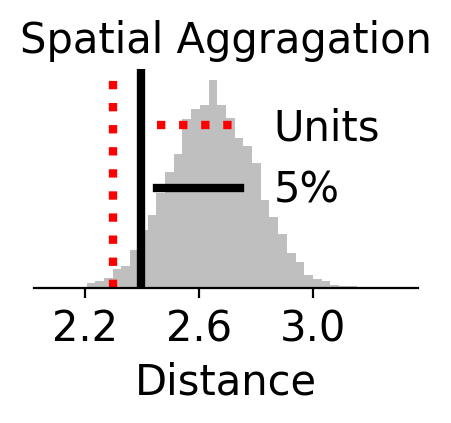

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(2, 2), dpi=200, constrained_layout=1)
axs.patch.set_alpha(0)

axs.hist(rand_all_sd, color='grey', alpha=0.5, bins=40)
axs.axvline(sd_trial_beta, color='r', linewidth=3, label='Units', linestyle='dotted')
axs.axvline(np.sort(rand_all_sd)[int(rand_all_sd.shape[0]*0.05)], color='k', linewidth=3, label='5%')
axs.legend(frameon=0, fontsize=15, loc=1)
axs.set_xticks([2.2, 2.6, 3])
axs.set_xticklabels(axs.get_xticks(), fontsize=15)
#axs.set_yticklabels(axs.get_yticks().astype(int), fontsize=15)
#axs.set_ylabel('Number of units', fontsize=15)
axs.set_yticks([])
axs.set_title('Spatial Aggragation', fontsize=15)
sns.despine(ax=axs, top=True, right=True, left=True, bottom=False)
axs.set_xlabel('Distance', fontsize=15)
plt.show();
